# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive")

Mounted at /content/drive


**Installing surprise library**

In [ ]:
pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811637 sha256=1293bff6dfff6d578eb7b63ed8206ebd0da8f04e8360762c96eb836b6448ed51
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [ ]:
# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np, pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization
import seaborn as sns

# A dictionary output that does not raise a key error
from collections import defaultdict

# A performance metrics in sklearn
from sklearn.metrics import mean_squared_error

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
# Importing the dataset
data= pd.read_csv('ratings_Electronics.csv', header=None, names=['user_id', 'prod_id','rating', 'timestamp' ] )
data.head()
# Dropping the "timestamp" column
df = data.drop("timestamp", axis = 1)
df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [ ]:
df.nunique()

user_id    4201696
prod_id     476002
rating           5
dtype: int64

In [ ]:
df.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

In [ ]:
df_final.shape

(65290, 3)

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns and provide observations
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 125871 entries, 94 to 7824444
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  125871 non-null  object 
 1   prod_id  125871 non-null  object 
 2   rating   125871 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.8+ MB


Thre are 125871 observations and three variables: user_id, prod_id and rating. The first two are strings the other is a float.

### **Data types**

In [ ]:
# Check Data types and provide observations
# already done above, see question above.

user_id and product id are strings, rating is a float

### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
df_final.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

There are no missing values

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
df['rating'].describe()

count    125871.000000
mean          4.261339
std           1.062144
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

Rating has 125871 observations. The mean rating is 4.26 and the standard deviation is 1.06. The minimum rating is 1 and the maximum 5. The first quartile is 4 and the second 5. Thus, most ratings are at the maximum.

### **Checking the rating distribution**

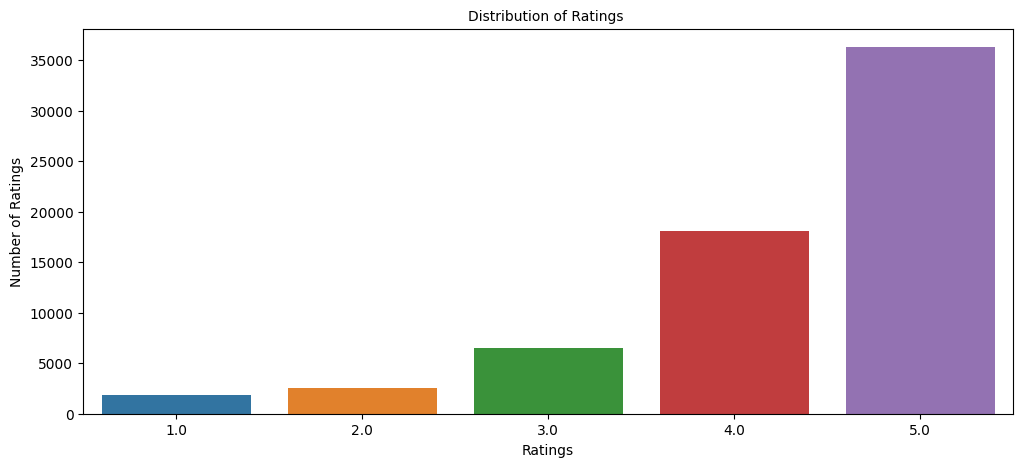

In [ ]:
# Create the bar plot and provide observations
# Fix the figure size
plt.figure(figsize = (12, 5))

ax = sns.countplot(x = "rating", data = df_final)

plt.tick_params(labelsize = 10)

plt.title("Distribution of Ratings ", fontsize = 10)

# Set the xlabel of the plot
plt.xlabel("Ratings", fontsize = 10)

# Set the ylabel of the plot
plt.ylabel("Number of Ratings", fontsize = 10)

# Display the plot
plt.show()

The distribution is left-skewed. 35000 observations have a rating of 5 and less htan 5000 observations contain a rating of 1 or 2. Less than 10,000 ratings given with the value 4  and less than 20.000 times was a product rated 4.

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data
df_final.nunique()

user_id    1540
prod_id    5689
rating        5
dtype: int64

There are 1540 unique costumers in the sample of our dataset and they rated 5689 unique products. The rating contains 5 categories.

### **Users with the most number of ratings**

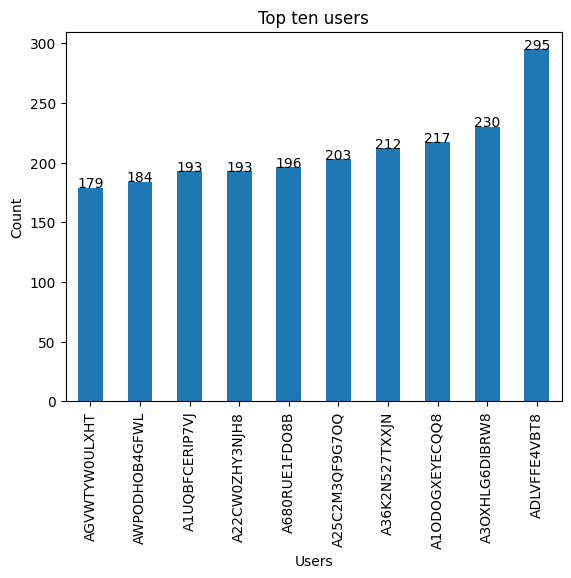

In [ ]:
# Top 10 users based on the number of ratings
# since there are no missing values each row in the dataset represents a product with a rating
plt.title('Top ten users')
ax=df_final.user_id.value_counts()[:10].sort_values(ascending=True).plot(kind='bar', rot=0)
plt.xticks(rotation = 90)
for p in ax.patches:
  label = p.get_height()  # Count of each level of the category
  x = p.get_x() + p.get_width() / 2  # Width of the plot
  y = p.get_height()
  ax.annotate(
      label,
       (x, y),
      ha = "center")
plt.xlabel('Users')
plt.ylabel('Count')
plt.show()

The top ten users have given between 295 and 179 ratings. Only one user has 295 ratings, the user with the second most ratings has rated 230 items, followed by 217 items, 212 and 203. The other users have given less than 200 ratings.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id').mean()['rating']
# Calculate the count of ratings for each product
rating_freq = df_final.groupby('prod_id').count()['rating']
# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'average_rating':average_rating, 'rating_freq':rating_freq})
# Sort the dataframe by average of ratings in the descending order
final_rating= final_rating.sort_values(by= 'average_rating', ascending=False)
# See the first five records of the "final_rating" dataset
final_rating.head(5)



,average_rating,rating_freq
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_ratings(data, n, min_interactions):
  # Finding products with minimum number of interactions
  recommendations = data[data['rating_freq'] >= min_interactions]

  # Sorting values with respect to average rating
  recommendations = recommendations.sort_values(by='average_rating', ascending=False)

  return recommendations.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
list(top_n_ratings(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

The top 5 products with 50 minimu interactions based on popularity are B001TH7GUU, B003ES5ZUU, B0019EHU8G, B006W8U2MU and B000QUUFRW.

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
list(top_n_ratings(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B002WE6D44', 'B007WTAJTO', 'B002V88HFE']

The top 5 products with 100 minimu interactions based on popularity are B003ES5ZUU, B000N99BBC, B002WE6D44, B007WTAJTO and B002V88HFE.

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))
# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id','rating']], reader)
# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.40, random_state=42)


Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)


RMSE: 1.0347
Precision:  0.867
Recall:  0.7
F_1 score:  0.775


The root means square error is 1.0347. Predision is about 87%, recall 70% and the F_1_score is approximatley 78%.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.00   {'actual_k': 4, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.0, details={'actual_k': 4, 'was_impossible': False})

The predicted rating for  user A3LDPF5FMB782Z on  item 1400501466 is 3.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
userlist=df_final[df_final['prod_id'] != "1400501466" ]['user_id'].unique()
for item in userlist:
  print(item)

A2ZR3YTMEEIIZ4
A3CLWR1UUZT6TG
A5JLAU2ARJ0BO
A1P4XD7IORSEFN
A341HCMGNZCBIT
A3HPCRD9RX351S
A1DQHS7MOVYYYA
ALUNVOQRXOZIA
A19N3S7CBSU6O7
A3G7BEJJCPD6DS
A2JXS1JII6SAUD
A1C82BC5GNABOA
A1VHCO8RQFIGQJ
A2Z9S2RQD542CP
A2QIC4G483SQQA
A3L6L5O89JTX2T
A1OGCPMSIVK7G4
A18HE80910BTZI
A3F9CBHV4OHFBS
A1T1YSCDW0PD25
ABVYGB2TKBO8F
A11ED8O95W2103
A3NCIN6TNL0MGA
ASHJAZC9OA9NS
A105TOJ6LTVMBG
A14JBDSWKPKTZA
A3QX0ERX4D03TF
A13WREJ05GMRA6
A3N8O68DOEQ2FE
A3J8A5L5AF5TX9
A2HRHF83I3NDGT
A1R3GN9MEJFXM3
A3963R7EPE3A7E
A2JOPUWVV0XQJ3
AAW7X3GRD8GY9
A3V8P0O224OBDB
AY6A8KPYCE6B0
A212MDP6K4VJS5
A28X0LT2100RL1
A1V3TRGWOMA8LC
A1NZLRAZJGD99W
A1522TN5FVJL0Y
A3UXW18DP4WSD6
A3CW0ZLUO5X2B1
A3TBMGNSEQBWIL
AEZJTA4KDIWY8
A22CW0ZHY3NJH8
A2V7EO331SFUF6
A3977M5S0GIG5H
A1F1A0QQP2XVH5
A231WM2Z2JL0U3
A2JWF9IG8PJAOA
A3LWC833HQIG7J
A38RMU1Y5TDP9
A3D822N1K2IAQD
A33775AIB1A664
ARXU3FESTWMJJ
A3A15L96IYUO6V
A3PGVJF37JSHFO
A2WJ5XSE4I9F55
A1V5TRJXTI6F01
ATOKT8QYK967L
ANRS196NKFVUU
A3639Z6O5JBLIZ
A3ER6ARJ23CIN8
A33152QEGO2MZN
A3HRDRQ5VAFPQS
A1KY5G

In [ ]:
if "A34BZM6S9L7QI4" in userlist:
  print('yes')

yes


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict('A34BZM6S9L7QI4 ', '1400501466',  verbose=True)

user: A34BZM6S9L7QI4  item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4 ', iid='1400501466', r_ui=None, est=4.2901924746005005, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

User A34BZM6S9L7QI4 has a predicted rating of 4.29 on item 1400501466.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ["cosine",'pearson',"pearson_baseline"],
                              'user_based': [True], "min_support":[2,4]}
              }
# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
# Fitting the data
gs.fit(data)
# Best RMSE score
print(gs.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9795769561803692
{'k': 30, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': True, 'min_support': 2}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'pearson_baseline',
               'user_based': True, "min_support":2}
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options, k=30, min_k=9, random_state=1, verbose=False)
# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)
# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)






RMSE: 0.9836
Precision:  0.832
Recall:  0.7
F_1 score:  0.76


The root mean square error is 0.9836 thus it decreased. Precision is approx. 83% and recall 70%, the F_1 score is 76%.The tuning improved the root mean square error.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimized.predict('A3LDPF5FMB782Z', '1400501466',  verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.2901924746005005, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimized.predict('A34BZM6S9L7QI4', '1400501466',  verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.2901924746005005, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

For both users the predicted rating is 4.29 on item 1400501466.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0,5)


[14, 534, 646, 600, 29]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final,'A3LDPF5FMB782Z', 5, sim_user_user)
recommendations

[('B00001W0DI', 5),
 ('B00002EQCW', 5),
 ('B00003006R', 5),
 ('B00004W3ZQ', 5),
 ('B00004WCFT', 5)]

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])


,prod_id,predicted_ratings
0,B00001W0DI,5
1,B00002EQCW,5
2,B00003006R,5
3,B00004W3ZQ,5
4,B00004WCFT,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'pearson',
               'user_based': False}
# KNN algorithm is used to find desired similar items. Use random_state=1
sim_item_item = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)
# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)


RMSE: 1.0232
Precision:  0.834
Recall:  0.699
F_1 score:  0.761


The root mean square error is 10232, precision is 83% and recall is 69.9%. The F_1 score is 76.1%. In comparison to the other models precision slighltiy increased but neihter  recall nor the F_1 score improved.

\Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
df_final[df_final['user_id']=='A3LDPF5FMB782Z' ].head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
504686,A3LDPF5FMB782Z,B0002SQ0A4,4.0
675474,A3LDPF5FMB782Z,B0009O6IXA,1.0
1017085,A3LDPF5FMB782Z,B000HZDF8W,3.0
1047368,A3LDPF5FMB782Z,B000IF4788,5.0


In [ ]:
# Predicting rating for a sample user with an interacted product

sim_item_item.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 5.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=5, details={'actual_k': 1, 'was_impossible': False})

The predicted rating for user A3LDPF5FMB782Z  for item 1400501466 is 5 which corresponds with the actual rating given for this item by the user.


Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict('A34BZM6S9L7QI4 ', '1400501466',  verbose=True)

user: A34BZM6S9L7QI4  item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4 ', iid='1400501466', r_ui=None, est=4.2901924746005005, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

The estimated rating for user  A34BZM6S9L7QI4 for item 1400501466 is 4.29.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ["msd", "cosine"],
                              'user_based': [False]}
              }
# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
# Fitting the data
gs.fit(data)
# Find the best RMSE score
print(gs.best_score['rmse'])
# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9761725173616185
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name':"cosine",
               'user_based': False, }
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options=sim_options, k=30, min_k=6, random_state=1, verbose=False)
# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)
# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9761
Precision:  0.835
Recall:  0.699
F_1 score:  0.761


The root mean sqare error is 0.9761 and precision is 83.5%, whiel recal is 0.699 and the F_1 score is 76.1%. The  root mean square error decreased in compoarison to the earlier models and precision slightly increased. Recall and the F_1 score is the same as in the untuned version.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'actual_k': 17, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.294117647058823, details={'actual_k': 17, 'was_impossible': False})

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_item_item_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.2901924746005005, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

The estimation is worth than the baseline model. The predicted rating for user A3LDPF5FMB782Z for item 1400501466 is 4.29 while it was 5 for the untuned model and the actual rating is 5. For user A34BZM6S9L7QI4 the prediction remains the same.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
sim_item_item_optimized.get_neighbors(0, k=5)

[117, 144, 151, 156, 157]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, sim_item_item)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.290192
1,1400599997,4.290192
2,9983891212,4.290192
3,B00000DM9W,4.290192
4,B00000J1V5,4.290192


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)
# Training the algorithm on the trainset
svd.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)


RMSE: 0.9032
Precision:  0.87
Recall:  0.708
F_1 score:  0.781


The RMSE is 0.9032 and the precison 87%. Recall is 70.8% en the F_1 score 78.1%.   In comparison to the other models so far this is model performs best.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
df_final[df_final['user_id']=='A3LDPF5FMB782Z'].head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
504686,A3LDPF5FMB782Z,B0002SQ0A4,4.0
675474,A3LDPF5FMB782Z,B0009O6IXA,1.0
1017085,A3LDPF5FMB782Z,B000HZDF8W,3.0
1047368,A3LDPF5FMB782Z,B000IF4788,5.0


In [ ]:
# Making prediction
svd.predict('A3LDPF5FMB782Z',  '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.084585882575799, details={'was_impossible': False})

THe predicted rating is 4.08 and the actual rating  is 5 for user 1400501466  on item 1400501466

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
svd.predict('A34BZM6S9L7QI4',  '1400501466',  verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.11   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.107707909926497, details={'was_impossible': False})

The predicted rating for user A34BZM6S9L7QI4 for item 1400501466 is 4.11 which is lower than in the other models.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}
# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_.fit(data)
# Best RMSE score
print(gs_.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.8971875686399852
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2, random_state=1)
# Train the algorithm on the trainset
svd_optimized=svd_optimized.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8945
Precision:  0.874
Recall:  0.702
F_1 score:  0.779


The root mean square is 0.8945 which is the lowest so far. The prcision is 87.4%  which is the highest so far and the recall is 70.2%. The F_1 score is 77.9% which is close to the untuned version.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.25   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.25474003285863, details={'was_impossible': False})

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict('A34BZM6S9L7QI4',  '1400501466',  verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.11   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.111055635454275, details={'was_impossible': False})

The newly predicted ratings the same  for  user wihtout interaction but slightly higer than in the  non-tuned model for the user with an actual rating of 5. Still is the estimated rating of 4.25 lower than the actual rating.

### **Conclusion and Recommendations**

In this case study, we built recommendation systems using 4 different algorithms. They are as follows:

Rank-based using averages
User-user-similarity-based collaborative filtering
Item-item-similarity-based collaborative filtering
Model-based (matrix factorization) collaborative filtering

We have seen how they are different from each other and what kind of data is needed to build each of these recommendation systems. We can further combine all the recommendation techniques we have seen.

To demonstrate "user-user-similarity-based collaborative filtering","item-item-similarity-based collaborative filtering", and "model-based (matrix factorization) collaborative filtering", surprise library has been demonstrated. For these algorithms grid search cross-validation is used to find the best working model, and using that the corresponding predictions are made.

Proposal for the final solution design:
We will use the model-based (matrix factorization) collaborative filtering recommendation system final solution since it gives a high F_1 score.